In [5]:
import torch
import torchvision.models as models
from torchvision import datasets, models, transforms
import torch.nn as nn
import numpy as np

import sys 
import os
import torch.nn.functional as F

sys.path.append(os.path.abspath('Score-CAM/'))

from utils import *
from cam.scorecam import *

## Define a dataloader

In [6]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, data_dir, mu = None, std = None):
    super(CustomDataset, self).__init__()
    # store the raw tensors
    
    self._x= np.load(data_dir+'/data.npy')
    self._y = np.load(data_dir+'/labels.npy')
    print("data loaded")
    print("Shape: ",self._x.shape)
    if mu is None or std is None:
        print("calculating mean and std")
        self.mu = np.mean(self._x)
        self.std = np.std(self._x)
        print("std and mu calculated")
    else:
        self.mu = mu
        self.std = std
    
    self.compose = transforms.Compose([
                              transforms.Normalize((self.mu), (self.std))])
    self.classes = ["no_kidney", "kidney"]

  def __len__(self):
    # a DataSet must know its size
    return self._x.shape[0]

  def __getitem__(self, index):
    
    x = self._x[index, :]
    y = self._y[index]
    
    if len(x.shape) == 2:
        #convert grayscale to RGB
            x=torch.from_numpy(x)
            x=torch.stack([x,x,x],0)
            
            #x=x.numpy()
            
    x = self.compose(x)
    return x, y

## Load the validation dataset

In [7]:
data_dir = '/gpfs/space/home/joonas97/data/kits21/2dslices/'


#train_dataset = CustomDataset(os.path.join(data_dir, "train"))
                              
val_dataset = CustomDataset(os.path.join(data_dir, "val"))

data loaded
Shape:  (1528, 512, 512)
calculating mean and std
std and mu calculated


## Load segmentatation maps

In [8]:
seg_maps = np.load('/gpfs/space/home/joonas97/data/kits21/2dslices/val_data_segmentation_maps.npy')

In [9]:
np.unique(seg_maps[100], return_counts=True)

(array([0., 1.]), array([259833,   2311]))

## Load trained model (based on resnet50)

In [10]:
resnet = models.resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)
resnet.load_state_dict(torch.load('test_model'))
resnet.eval()


resnet_model_dict = dict(type='resnet50', arch=resnet, layer_name='layer4',input_size=(512, 512))
resnet_scorecam = ScoreCAM(resnet_model_dict)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import *

discrete_cmap = ListedColormap(['#53c972','#e3c634', '#2a5fbd'])
discrete_cmap.set_under(color = 'white', alpha = 0)
boundaries = [0.1, 1.1, 2.1, 3.1]
norm = BoundaryNorm(boundaries, discrete_cmap.N)

## Get saliency maps and visualize them 

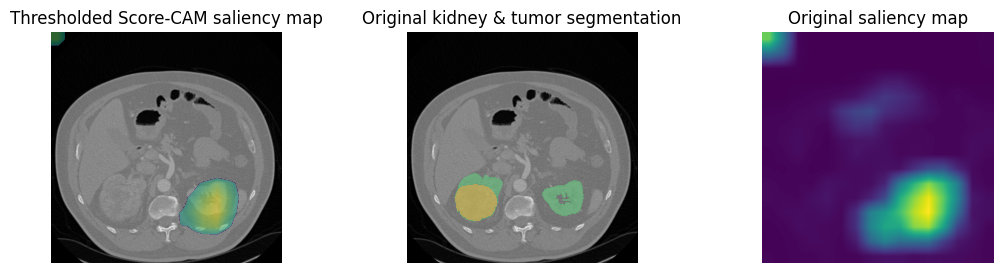

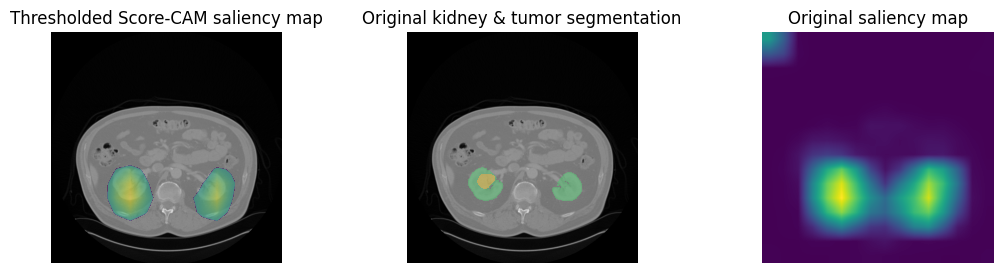

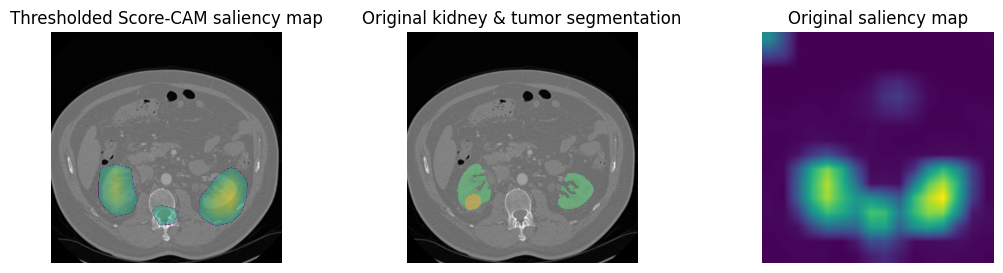

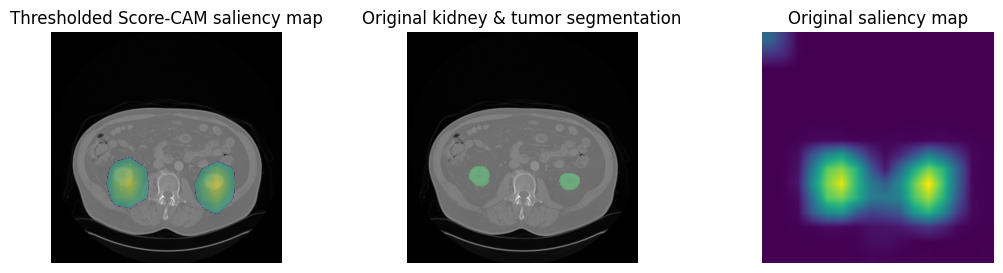

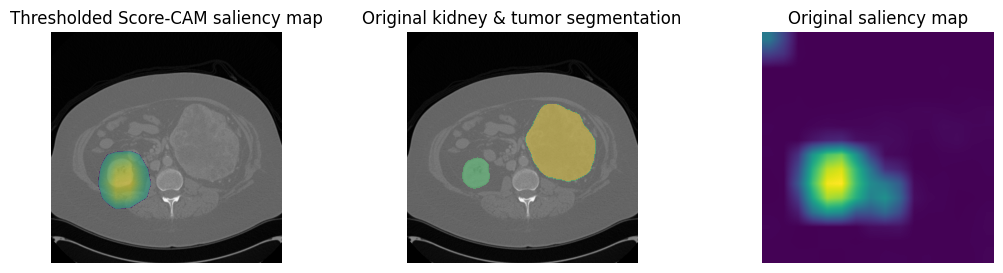

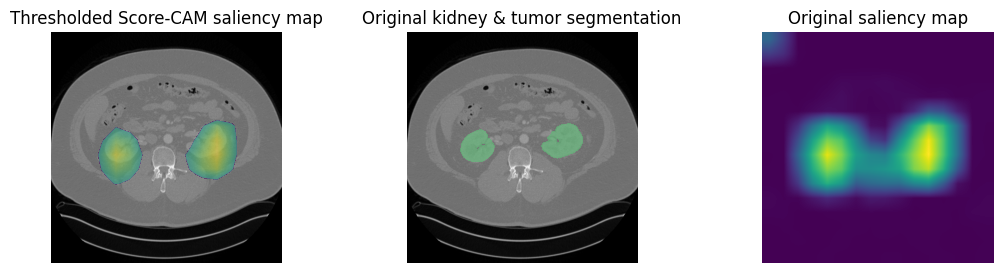

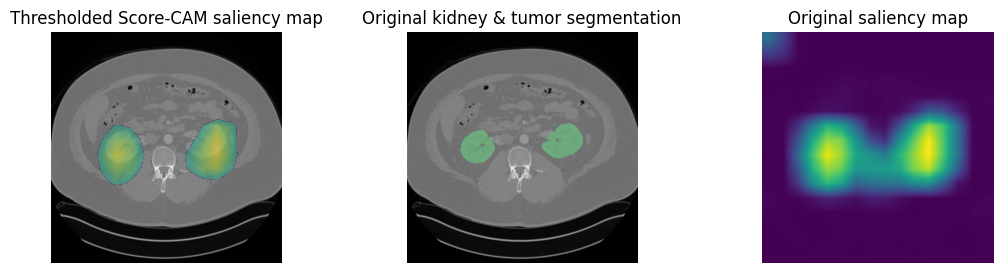

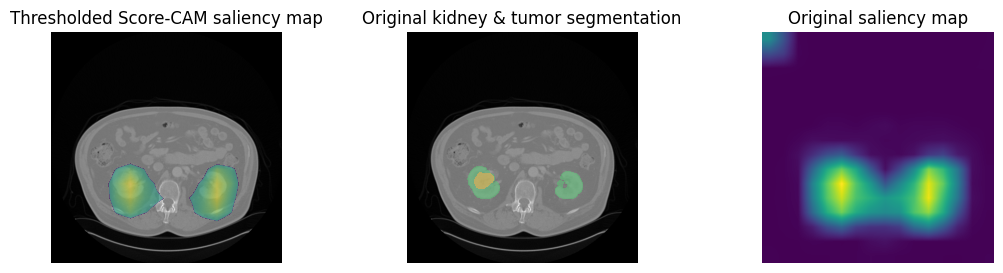

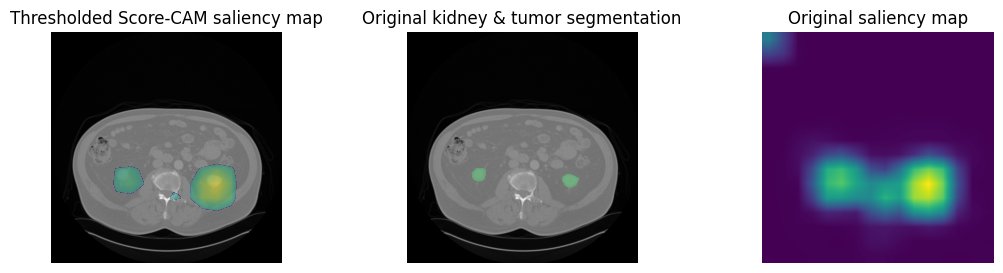

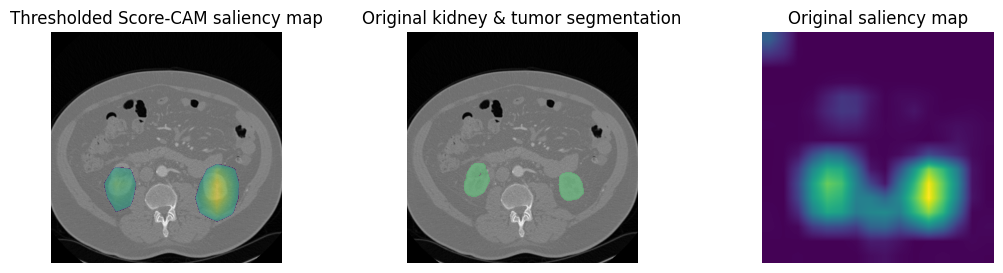

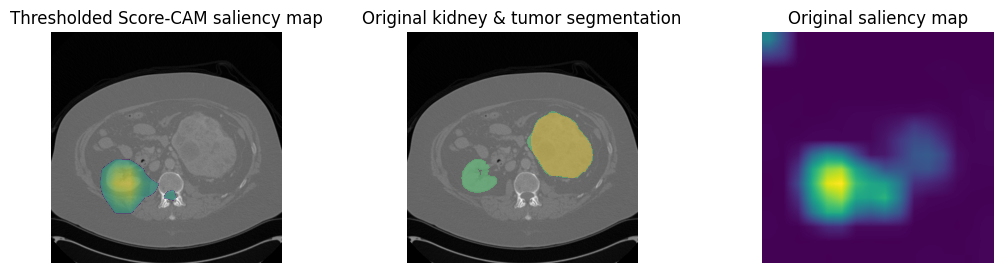

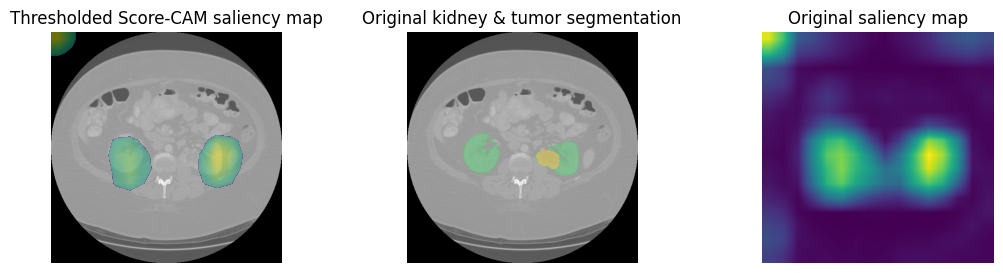

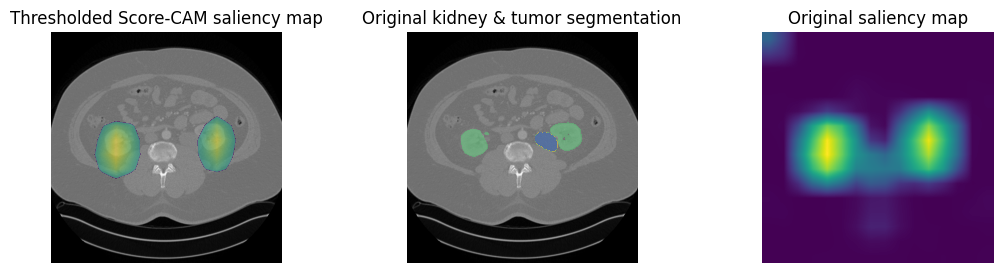

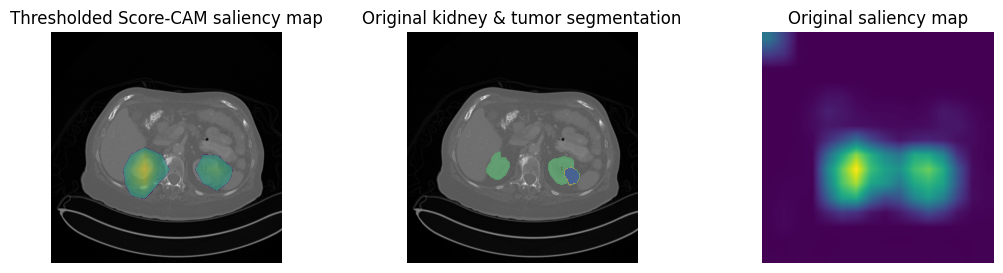

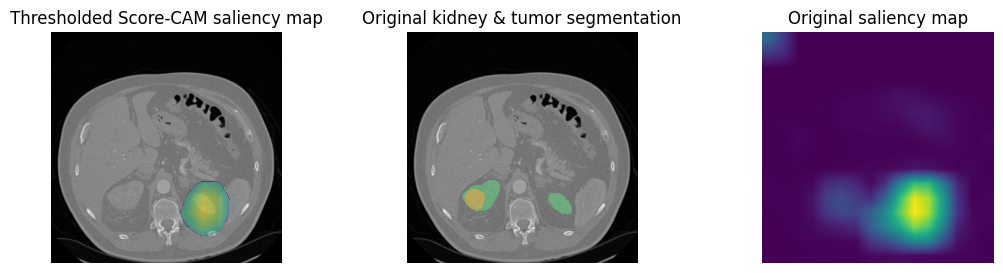

In [30]:
for i in np.random.choice(np.arange(764),15, replace = False):
    input_image = val_dataset[i][0].float().unsqueeze(0)

    if torch.cuda.is_available():
      input_image = input_image.cuda()
    predicted_class = resnet(input_image).max(1)[-1]

    scorecam_map = resnet_scorecam(input_image)
    
    threshold = .6
    
    # create thresholded saliency map
    thresholded_attention = torch.zeros_like(scorecam_map)
    mask = scorecam_map >= threshold
    thresholded_attention[mask] = scorecam_map[mask]
    
    fig = plt.figure(figsize=(13, 3))
    ax = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)
    

    ax.imshow(input_image[0,0].cpu(), cmap = 'gray')
    cmap = plt.get_cmap('viridis')
    cmap.set_under(color = 'white', alpha = 0)
    ax.imshow(thresholded_attention[0,0].type(torch.FloatTensor).cpu(), cmap = cmap, alpha= 0.5,vmin=0.1)
    ax.set_title("Thresholded Score-CAM saliency map")
    ax.set_axis_off()
    
    ax2.imshow(input_image[0,0].cpu(), cmap = 'gray')
    ax2.imshow(seg_maps[i], alpha = 0.5, cmap = discrete_cmap, norm = norm)
    ax2.set_title("Original kidney & tumor segmentation")
    ax2.set_axis_off()
    
    ax3.imshow(scorecam_map[0,0].cpu())
    ax3.set_title("Original saliency map")
    ax3.set_axis_off()
    plt.savefig("figs/2d_cam_fig_nr"+str(i))
    plt.show()
    

In [117]:
len(val_dataset)

1528

/gpfs/space/home/joonas97/.conda/envs/KITSCAM/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/gpfs/space/home/joonas97/kitscam/Score-CAM/cam/scorecam.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logit = F.softmax(logit)
/gpfs/space/home/joonas97/kitscam/Score-CAM/cam/scorecam.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(output)


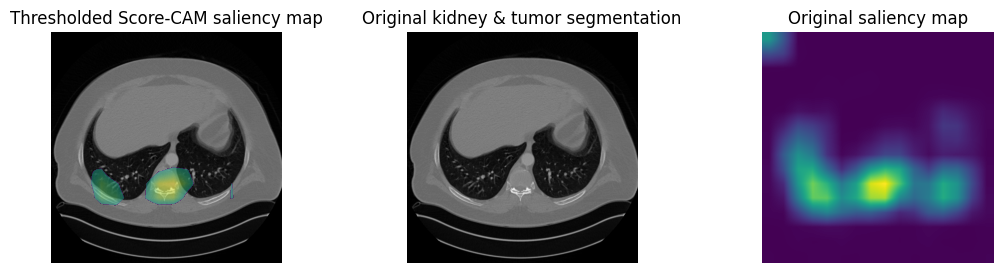

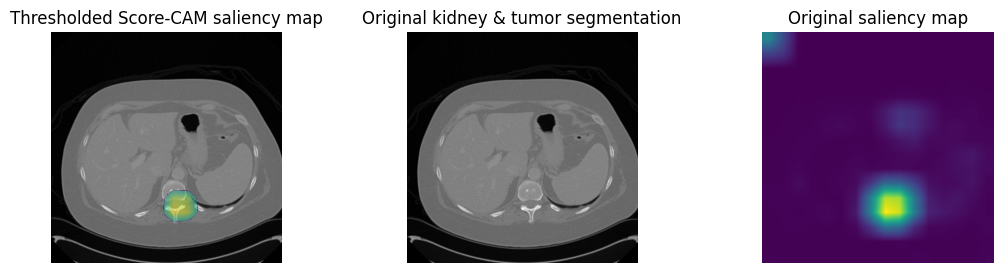

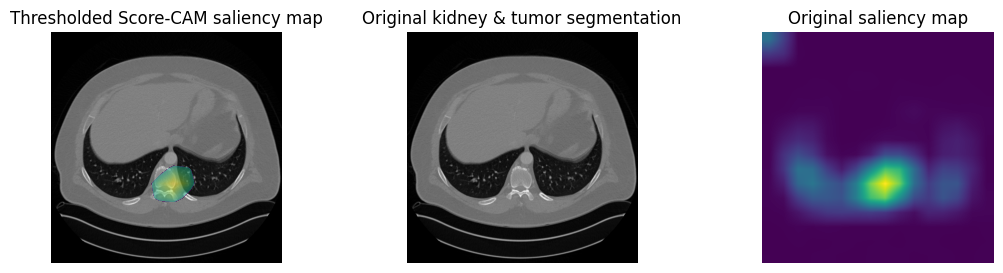

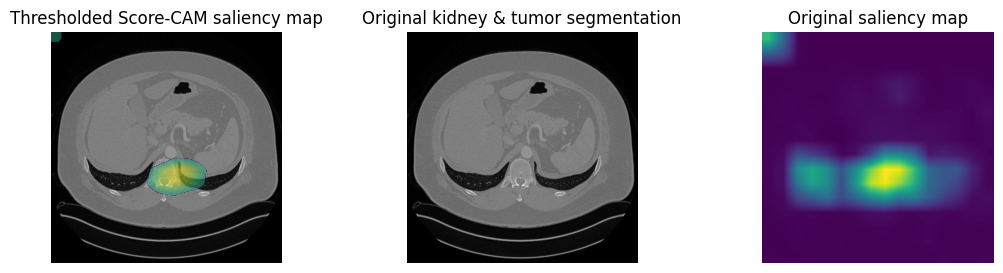

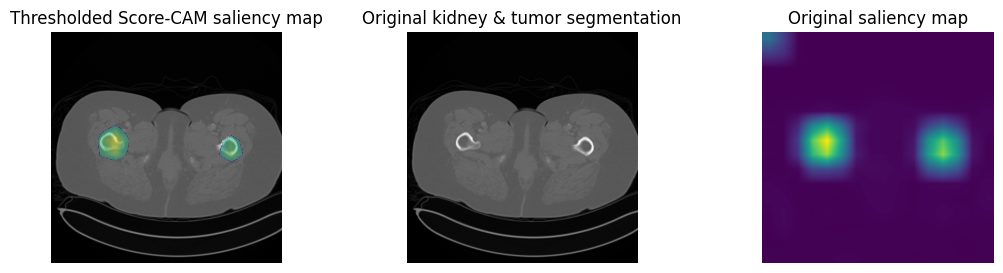

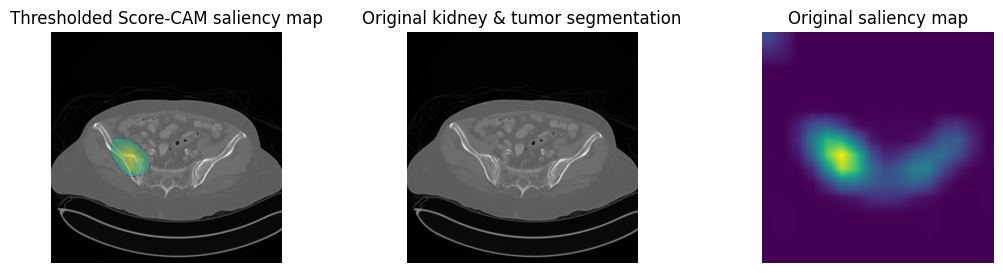

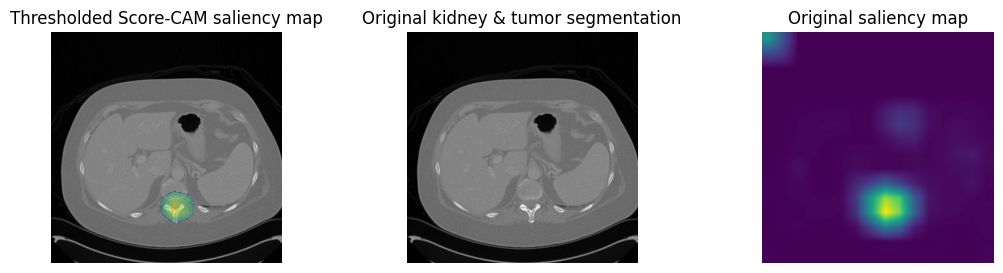

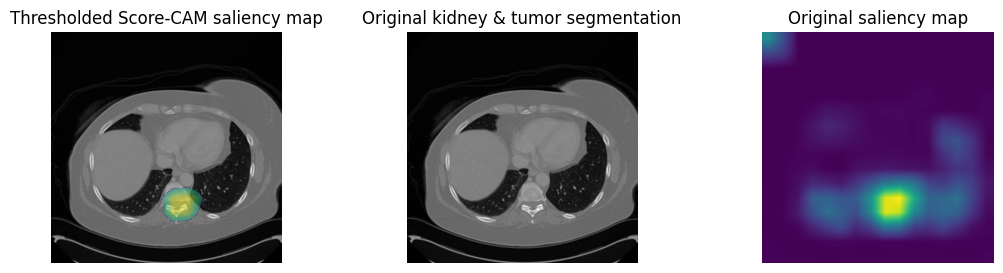

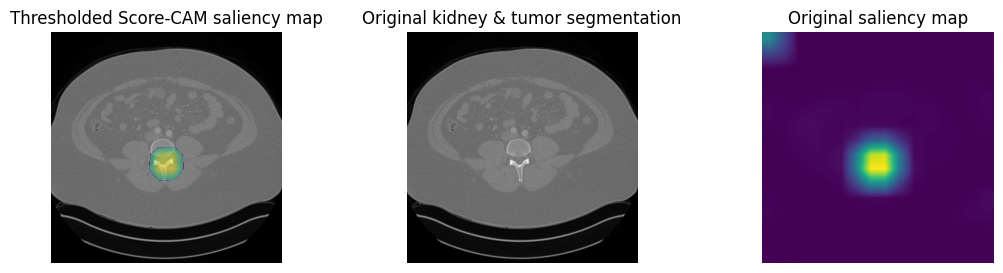

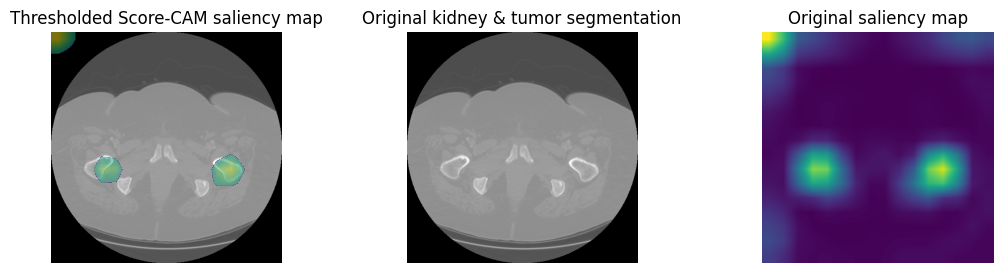

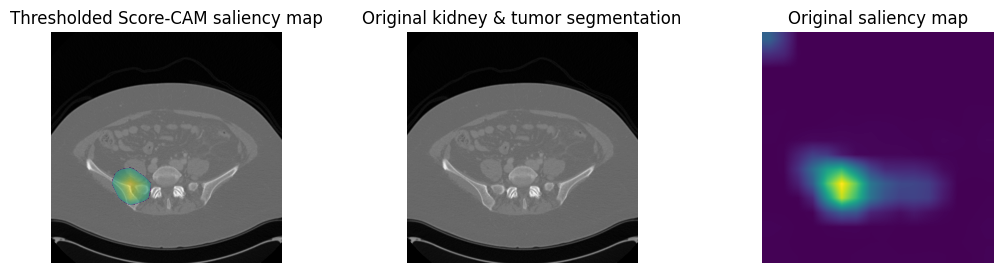

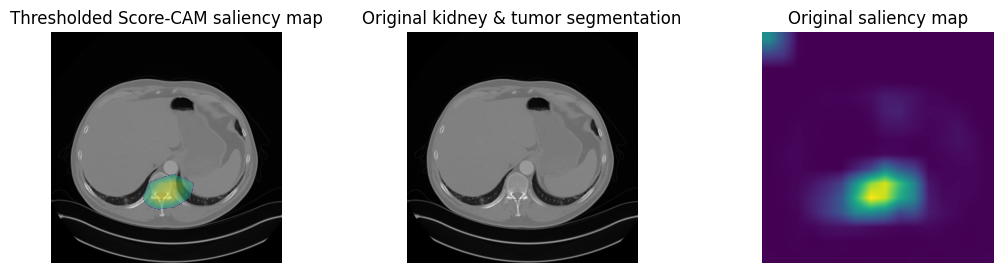

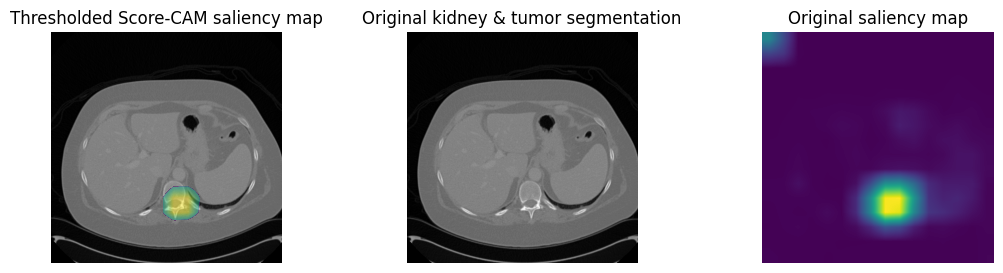

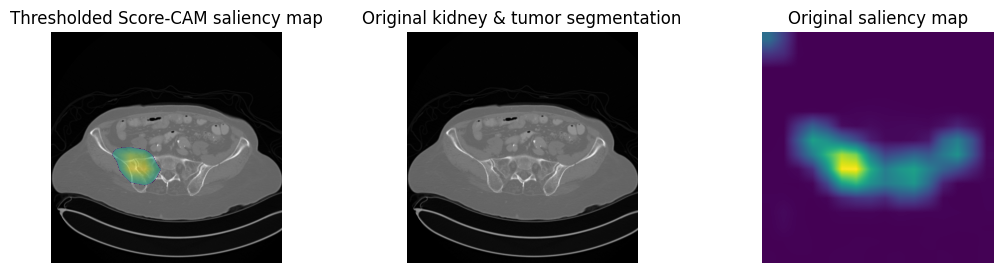

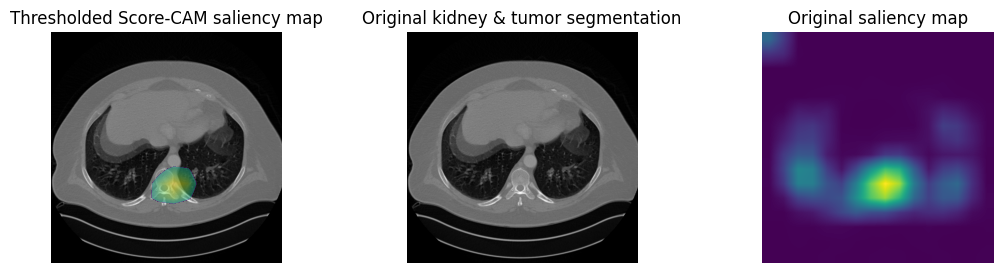

In [12]:
for i in np.random.choice(np.arange(764,1528),15, replace = False):
    input_image = val_dataset[i][0].float().unsqueeze(0)

    if torch.cuda.is_available():
      input_image = input_image.cuda()
    predicted_class = resnet(input_image).max(1)[-1]

    scorecam_map = resnet_scorecam(input_image)
    
    threshold = .6
    
    # create thresholded saliency map
    thresholded_attention = torch.zeros_like(scorecam_map)
    mask = scorecam_map >= threshold
    thresholded_attention[mask] = scorecam_map[mask]
    
    fig = plt.figure(figsize=(13, 3))
    ax = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)
    

    ax.imshow(input_image[0,0].cpu(), cmap = 'gray')
    cmap = plt.get_cmap('viridis')
    cmap.set_under(color = 'white', alpha = 0)
    ax.imshow(thresholded_attention[0,0].type(torch.FloatTensor).cpu(), cmap = cmap, alpha= 0.5,vmin=0.1)
    ax.set_title("Thresholded Score-CAM saliency map")
    ax.set_axis_off()
    
    ax2.imshow(input_image[0,0].cpu(), cmap = 'gray')
    ax2.imshow(seg_maps[i], alpha = 0.5, cmap = discrete_cmap, norm = norm)
    ax2.set_title("Original kidney & tumor segmentation")
    ax2.set_axis_off()
    
    ax3.imshow(scorecam_map[0,0].cpu())
    ax3.set_title("Original saliency map")
    ax3.set_axis_off()
    plt.savefig("figs/2d_cam_no_kidney_fig_nr"+str(i))
    plt.show()
    

In [119]:
masked_data = np.random.random((100,100))
masked_data = np.ma.masked_where(masked_data < 0.9, masked_data)

In [120]:
masked_data

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., 0.9722479246638546, --, --],
        [--, --, --, ..., 0.9309489644337382, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, 0.959493250880919]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ..., False,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True, False]],
  fill_value=1e+20)

In [136]:
np.random.choice(np.arange(764,1528),25, replace = False)

array([1354,  970, 1526, 1287, 1138, 1182, 1197, 1128,  903, 1476, 1126,
       1282, 1342,  947, 1293,  936, 1208,  772, 1232,  922, 1056, 1195,
        931, 1114, 1514])

In [135]:
len(val_dataset)

1528

In [ ]:
import torch

In [ ]:
cu